In [1]:
# codefolding: https://github.com/ipython-contrib/jupyter_contrib_nbextensions
from functools import partial
from itertools import product

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('dark_background')
import numpy as np
import pandas as pd
import seaborn

from hlt.transform import (
  DIRS4, DIR_O, DIRS_ALL,
  yx2ngbrs, dist_mtn
  )
E,N,W,S=(0,1),(-1,0),(0,-1),(1,0)
O=(0,0)
from hlt.util import (
  flatmap, mapl, maps_itr, maps_func, memo, # DATA
  asrt, lvl2lgr, log, logitr, logaz, timit, # DEBUG
  )
logf=log.warning
timit = partial(timit, lvl='warn')

In [2]:
def make_map(dim=8, min_max=(0,1000), _show=False):
  _map = np.random.uniform(*min_max, size=(dim,dim)).astype(int)
  if _show: show(_map)
  return _map
show = lambda mat: display(pd.DataFrame(mat))
@memo()
def c8c2c(yx0,dlt,dim): return (yx0[0]+dlt[0])%dim, (yx0[1]+dlt[1])%dim
def c8cs2c(yx0, dlts, dim): return c8c2c(yx0, tuple(map(sum,zip(*dlts))), dim)
@memo()
def yx2ngbrs(yx, dim):
  dirs = DIRS4#[E,N,W,S]
  return [c8c2c(yx,_dir,dim) for _dir in dirs]
# print(yx2ngbrs((3,0),4))
def hmap(mat, lmh=(None,None,None),colors='PiYG_r',**kwargs): # TODO backport plots() dark-style
  vmin,center,vmax = lmh
  kwargs['vmin'] = vmin
  kwargs['center'] = center
  kwargs['vmax'] = vmax
  cmap = plt.get_cmap(colors)
#   cmap.set_bad(color='black', alpha=np.nan)
  kwargs['cmap'] = cmap
  kwargs['annot'] = True
  kwargs['fmt'] = 'g'
  df = pd.DataFrame(mat).replace([np.inf,-np.inf], np.nan) # mask inf vals
  if 'ax' not in kwargs:
    fig, ax = plt.subplots(1,1, figsize=(7,6)) # dummy subplot just to give an ax
    kwargs['ax'] = ax
  heatmap = seaborn.heatmap(df,**kwargs)
# hmap(make_map(4))

In [3]:
from math import ceil, floor
from queue import PriorityQueue
"""BestFirstSearch
  scan for value
  seek path-cheapest: src -> tgt
  """
def pq(item_init=None, lvl='debug'):
  logf = lvl2lgr(lvl)
  def pq_put(item):
    _pq.put(item)
    logf('+ %s [%d]', item, _pq.qsize())
  def pq_get():
    item = _pq.get()
    logf('- %s [%d]', item, _pq.qsize())
    return item
  empty = lambda: _pq.empty()
#   stats = lambda: logf('# puts: %d; # gets: %d', n_puts, n_gets)
  _pq = PriorityQueue()
  if item_init: pq_put(item_init)
  return pq_put, pq_get, empty#, stats
# @timit() # TODO vectorize
def decay_map(_map, src, r_decay=1.):
  f = lambda yx: _map[yx] * r_decay**dist_mtn(src, yx, len(_map))
#   return np.vectorize(f)(_map)
  _decay_map = _map.copy()
  for yx, _ in np.ndenumerate(_decay_map):
    _decay_map[yx] = f(yx)
  return _decay_map
## seek path cheapest: src -> tgt
@timit()
def seek(_map, src, tgt, r_decay=1., r_cost_move=.1, lvl='debug'):
  dim = len(_map)
  cost_init = np.inf
  cost_map = np.full((dim,dim),fill_value=cost_init) # best cost-realized: src -> yx
  seen = lambda yx: cost_map[yx]!=cost_init
  _decay_map = decay_map(_map, src, r_decay)
  def cost_known(yx,cost=None): return cost_map[yx]
  def cost_guess(yx0,yx1): return dist_mtn(yx0,yx1,dim) # TMP heuristic cost-forward: yx -> tgt
  def cost_combo(yx0,yx1): return cost_known(yx0) + cost_guess(yx0,yx1)
  put, get, empty = pq(lvl=lvl,
    item_init=(0, cost_guess(src,tgt), src),) # seed: known, guess, yx
  i = 0
  while not empty():
    i+=1
    known, guess, yx_curr = get()
    if known < cost_known(yx_curr): # 1st visit = cheapest -> update maps
      cost_map[yx_curr]=known # update w/ better cost-realized
      if yx_curr == tgt:
        log.warning('@%s after %d iters!', tgt, i)
        break
      for yx_ngbr in [yx for yx in yx2ngbrs(*yx_curr, dim) if not seen(yx)]:
        if cost_guess(yx_ngbr,tgt) < cost_guess(yx_curr,tgt): # OPTI
          cost_ngbr = floor(cost_known(yx_curr) + _decay_map[yx_curr]*r_cost_move)
          put( (cost_ngbr, cost_guess(yx_ngbr,tgt), yx_ngbr) )
  return _map, _decay_map, cost_map
## scan -> flatten values: future -> present
@timit()
def scan(_map, cost2depot_map, src, rev=False, perim=2, r_decay=1., r_cost_move=.1, lvl='debug'): # rev: reverse cost source for cost2depot
  logf = lvl2lgr(lvl)
  dim = len(_map)
  cost_init = np.inf
  cost_map = np.full((dim,dim),fill_value=cost_init)
  seen = lambda yx: cost_map[yx]!=cost_init
  _decay_map = decay_map(_map, src, r_decay) # OPT
  val_map = np.full((dim,dim),fill_value=-cost_init) # ~= _decay_map - cost_map
  def clj_backtrack(): # back-propagate outer values (after update) -> 5 moves
    backtrack_map = np.full((dim,dim),fill_value=-np.inf)
    backtrack_map[src] = val_map[src]
    curr2prev = {src: src} # link cells: outer -> inner
    def back_ptr(yx_curr, yx_prev): # stores curr->prev then returns prev
      curr2prev[yx_curr] = yx_prev
      return yx_prev
    def backtrack(yx_curr, yx_prev):
      # update yx_curr
      dist = dist_mtn(yx_curr, src, dim)
      new_back_curr = max(
        floor(val_map[yx_curr]*(r_decay**dist)), 
        backtrack_map[yx_curr])
      if new_back_curr != backtrack_map[yx_curr]:
        # logf('%so>%s: %s->%s', yx_curr, yx_curr, backtrack_map[yx_curr], new_back_curr)
        backtrack_map[yx_curr] = new_back_curr
      # update prev
      if yx_prev!=src:
        dist = dist_mtn(yx_prev, src, dim)
        new_back_prev = max(
          floor(backtrack_map[yx_curr]*r_decay),
          floor(val_map[yx_prev]*(r_decay**dist)),
          backtrack_map[yx_prev])
        if new_back_prev != backtrack_map[yx_prev]:
          # logf('%s->%s: %s->%s', yx_curr, yx_prev, backtrack_map[yx_prev], new_back_prev)
          backtrack_map[yx_prev] = new_back_prev
        backtrack(yx_prev, curr2prev[yx_prev]) # pass new info outside inward
    return back_ptr, backtrack, backtrack_map
  back_ptr, backtrack, backtrack_map = clj_backtrack()
  put, get, empty = pq(item_init=(0,0,src,src), lvl=lvl) # (cost,dist,yx_curr,yx_prev)
  while not empty():
    cost,dist,yx_curr,yx_prev = get()
    if cost < cost_map[yx_curr]: # 1st visit also cheapest -> update maps & backtrack
      cost_map[yx_curr] = cost
      # val_map[yx_curr] = _decay_map[yx_curr] - cost # cost: src -> tgt
      # val_map[yx_curr] = floor(_map[yx_curr]*(r_decay**dist)) - cost # cost: src -> tgt
      # cost: src -> tgt -> depot_nearest 
      # decay only during backtrack
      val_map[yx_curr] = _map[yx_curr] - cost - cost2depot_map[yx_curr]
      backtrack(yx_curr, yx_prev)
      if dist <= perim: # expand in-perim ngbrs
        for yx_ngbr in [yx for yx in yx2ngbrs(yx_curr, dim) if not seen(yx)]:
          source_cost = yx_curr if not rev else yx_ngbr # reverse approach direction <- cost2depot_map
          cost_ngbr = floor(cost + _map[source_cost]*r_cost_move) # decay val but not cost
          put( (cost_ngbr, dist+1, yx_ngbr, back_ptr(yx_ngbr, yx_curr)) )
    # else: # later visits only backtracks value
    #   backtrack(yx_curr, yx_prev, dist)
  return _map, _decay_map, cost2depot_map, cost_map, val_map, backtrack_map
# initial map -> initial cost-to-depot-map
def init_cost2depot(_map, depot):
  dim = len(_map)
  _,_,_,cost2depot_map,_,_ = scan(_map, cost2depot_map=np.full((dim,dim),0), src=depot, rev=True, perim=dim*2+1, r_decay=1.)
  return cost2depot_map.astype(int)
def init_cost_map(_map, cost2depot_map, src): # for logging only
  _,_,_,cost_map_init,_,_ = scan(_map, cost2depot_map, src=src, perim=len(_map), r_decay=1.)
  return cost_map_init

In [4]:
# params -> test maps
DIM = 6
VMIN, VMAX = 0, 100
MAP_INIT = make_map(DIM,(VMIN,VMAX),_show=True)

,0,1,2,3,4,5
0,80,29,19,10,41,98
1,10,55,12,46,77,66
2,55,68,56,74,62,6
3,85,0,92,30,11,21
4,44,41,47,45,77,82
5,66,45,85,47,1,39


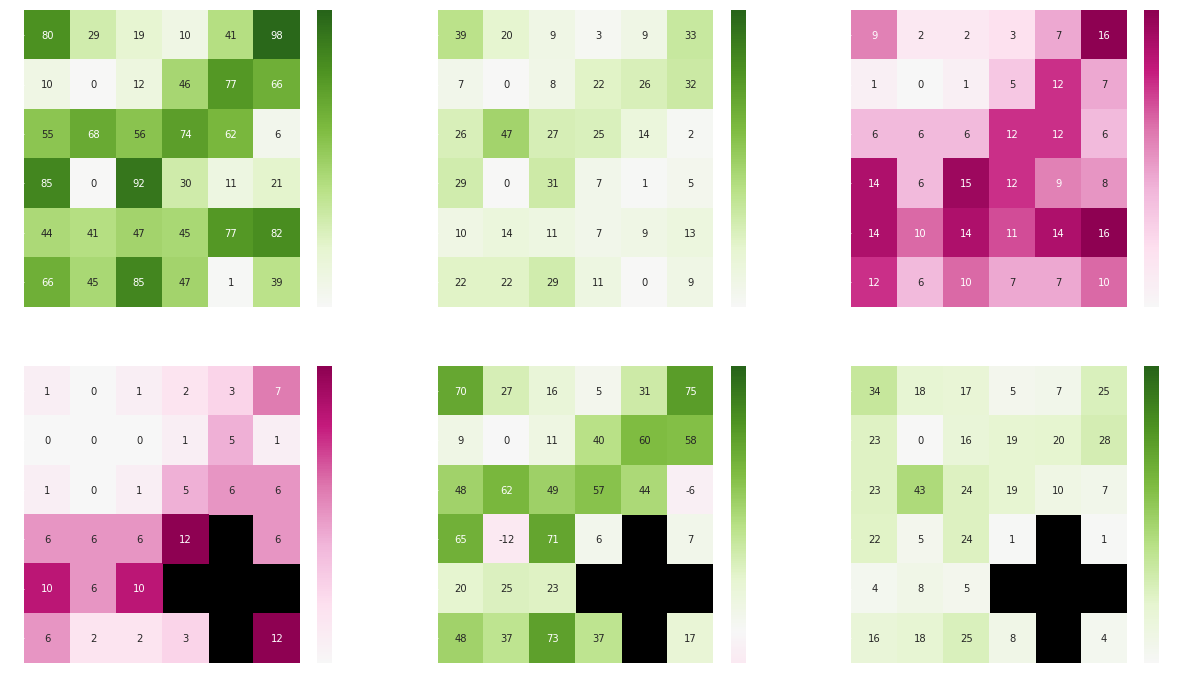

(1, 1)

In [5]:
# utils for debugging & visualizing BFS actions
@timit() # funcize subplot suite
def plots(min_max, _map, _decay_map, cost2depot_map, cost_map, val_map=None, backtrack_map=None):
  vmin,vmax = min_max
  h,w=2,3
  fig, ax = plt.subplots(h,w, sharey='row', figsize=(7*w,6*h))
  hmap(_map, lmh=(vmin,0,vmax), colors='PiYG', ax=ax[0,0])
  hmap(_decay_map, lmh=(vmin,0,vmax), colors='PiYG', ax=ax[0,1])
  hmap(cost2depot_map, lmh=(vmin,0,None), colors='PiYG_r', ax=ax[0,2])
  hmap(cost_map, lmh=(vmin,0,None), colors='PiYG_r', ax=ax[1,0])
  if not (val_map is None):
    hmap(val_map, lmh=(None,0,vmax), colors='PiYG', ax=ax[1,1])
#     hmap(_decay_map-cost_map, lmh=(None,0,vmax), colors='PiYG', ax=ax[1,1])
  if not (backtrack_map is None):
    hmap(backtrack_map, lmh=(None,0,vmax), colors='PiYG', ax=ax[1,2])
  plt.show()
R_COST_MOVE=.1
PERIM=3 # TODO paramize <- area ships_all-presence <- dynamicity
R_DECAY = .7
def get_costs(cost_map, src, dlts): # path-independent unlike cost_map[dst]
  costs = []
  for dlt in dlts:
    dst = c8c2c(src,dlt,DIM)
    costs.append( int(cost_map[dst]) )
  return costs
def move(_map, cost2depot_map, src, dlts, perim=PERIM, r_decay=R_DECAY):
  cost_map_init = init_cost_map(_map, cost2depot_map, src)
  dst = c8cs2c(src, dlts, DIM)
  _map, _decay_map, cost2depot_map, cost_map, val_map, backtrack_map = scan(_map, cost2depot_map, dst, perim=PERIM, r_decay=R_DECAY)
  logf('move: %s -> %s $ -%s', src, dst, int(cost_map_init[dst]))
  plots((VMIN,VMAX), _map, _decay_map, cost2depot_map, cost_map, val_map, backtrack_map)
  return dst
def pick(_map, cost2depot_map, src, dlts, perim=PERIM, r_decay=R_DECAY):
  cost_map_init = init_cost_map(_map, cost2depot_map, src)
  dst = c8cs2c(src, dlts, DIM)
  new_map = _map.copy()
  hlt_picked = ceil(new_map[dst] * 0.25)
  new_map[dst] -= hlt_picked
  cost2depot_map = init_cost2depot(new_map, DEPOT)
  new_map, _decay_map, cost2depot_map, cost_map, val_map, backtrack_map = scan(new_map, cost2depot_map, dst, perim=PERIM, r_decay=R_DECAY)
  logf('pick: %s -> @%s $ -%s +%d', src, dst, int(cost_map_init[dst]), hlt_picked)
  plots((VMIN,VMAX), new_map, _decay_map, cost2depot_map, cost_map, val_map, backtrack_map)
  return dst, new_map, cost2depot_map
## TODO automate target selection -> speedup testing
src = DEPOT = (1,1)
_map = MAP_INIT.copy()
_map[DEPOT] = 0
cost2depot_map = init_cost2depot(_map, depot=DEPOT)
move(_map, cost2depot_map, src, [O])

In [ ]:
# BOF 1
src, _map, cost2depot_map = pick(_map, cost2depot_map, src, [W]) # 0; 25;

In [ ]:
src, _map, cost2depot_map = pick(_map, cost2depot_map, src, [O]) # 0; 43;

In [ ]:
src, _map, cost2depot_map = pick(_map, cost2depot_map, src, [O]) # 0; 57;

In [ ]:
src, _map, cost2depot_map = pick(_map, cost2depot_map, src, [O]) # 0; 67;

In [ ]:
# move(_map, cost2depot_map, src, [S,S])
src, _map, cost2depot_map = pick(_map, cost2depot_map, src, [S,S]) # 9; 92; 83

In [ ]:
# 83:(E:62,N:67): cargocap: min dist-depot & future cost
# move(_map, cost2depot_map, src, [E])
src, _map, cost2depot_map = pick(_map, cost2depot_map, src, [E]) # 16; 108; 92

In [ ]:
# 92:(N:59): cargocap: min dist-depot & future cost
src, _map, cost2depot_map = pick(_map, cost2depot_map, src, [N]) # 20; 123; 103->100

In [ ]:
# 100: drop
src, _map, cost2depot_map = pick(_map, cost2depot_map, src, [N]) # 24; 123; 103->100-4=96; 78%; 6m7p